# Variable-speed synfire chains

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import numpy as np

from aux import Generic
from disp import set_font_size
from ntwk import LIFNtwkG, join_w

cc = np.concatenate

# PARAMS
## BASE MODEL
M = {
    # E mbrn dynamics
    'C_M_E': 1e-6, 'G_L_E': .1e-3,  # T_M_E = 10 ms
    'E_L_E': -0.06, 'V_TH_E': -0.05, 'V_R_E': -0.06, 'T_R_E': 0.002,
    
    # I mbrn dynamics
    'C_M_I': 1e-6, 'G_L_I': .2e-3,  # T_M_I = 5 ms
    'E_L_I': -0.06, 'V_TH_I': -0.05, 'V_R_I': -0.06, 'T_R_I': 0.002,
    
    # syn rev potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.002,
}

## SMLN
S = {
    'RNG_SEED': 0, 'DT': .0005
}

## Single excitatory neuron behavior

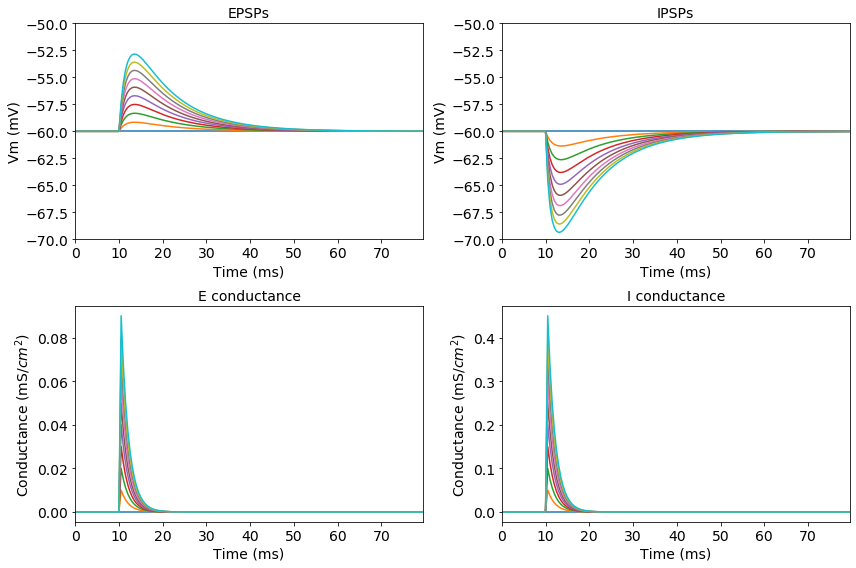

In [2]:
# EPSP size vs E weight
t = np.arange(0, .08, S['DT'])
rsps_e = []

for w_u_e_e in np.arange(10) * 0.01e-3:
    w_u_e_i = 0

    ntwk = LIFNtwkG(
        c_m=M['C_M_E'],
        g_l=M['G_L_E'],
        e_l=M['E_L_E'],
        v_th=M['V_TH_E'],
        v_r=M['V_R_E'],
        t_r=np.inf,
        e_s={'E': M['E_E'], 'I': M['E_I']},
        t_s={'E': M['T_E'], 'I': M['T_E']},
        w_r={'E': np.zeros([1]*2), 'I': np.zeros([1]*2)},
        w_u={'E': np.array([w_u_e_e, 0]), 'I': np.array([0, w_u_e_i])})
    
    spks_u = np.zeros((len(t), 2), dtype=int)
    spks_u[int(round(.01/S['DT'])), 0] = 1
    rsp = ntwk.run(
        dt=S['DT'],
        clamp=Generic(v={0: np.array([M['V_R_E']])}, spk={}),
        i_ext=np.zeros(len(t)),
        spks_u=spks_u)
    
    rsps_e.append(copy(rsp))
    

# IPSP size vs I weight
rsps_i = []

for w_u_e_i in np.arange(10) * 0.05e-3:
    w_u_e_e = 0

    ntwk = LIFNtwkG(
        c_m=M['C_M_E'],
        g_l=M['G_L_E'],
        e_l=M['E_L_E'],
        v_th=M['V_TH_E'],
        v_r=M['V_R_E'],
        t_r=np.inf,
        e_s={'E': M['E_E'], 'I': M['E_I']},
        t_s={'E': M['T_E'], 'I': M['T_E']},
        w_r={'E': np.zeros([1]*2), 'I': np.zeros([1]*2)},
        w_u={'E': np.array([w_u_e_e, 0]), 'I': np.array([0, w_u_e_i])})
    
    spks_u = np.zeros((len(t), 2), dtype=int)
    spks_u[int(round(.01/S['DT'])), 1] = 1
    rsp = ntwk.run(
        dt=S['DT'],
        clamp=Generic(v={0: np.array([M['V_R_E']])}, spk={}),
        i_ext=np.zeros(len(t)),
        spks_u=spks_u)
    
    rsps_i.append(copy(rsp))
    
    
# plot
fig, axs = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)
for rsp_e in rsps_e:
    axs[0, 0].plot(1000*t, 1000*rsp_e.vs[:, 0])
    axs[1, 0].plot(1000*t, 1000*rsp_e.gs['E'][:, 0])
for rsp_i in rsps_i:
    axs[0, 1].plot(1000*t, 1000*rsp_i.vs[:, 0])
    axs[1, 1].plot(1000*t, 1000*rsp_i.gs['I'][:, 0])
    
for ax in axs[0, :]:
    ax.set_xlim(1000*t.min(), 1000*t.max())
    ax.set_ylim(-70, -50)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Vm (mV)')
    
for ax in axs[1, :]:
    ax.set_xlim(1000*t.min(), 1000*t.max())
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Conductance (mS/$cm^2$)')
    
axs[0, 0].set_title('EPSPs')
axs[0, 1].set_title('IPSPs')

axs[1, 0].set_title('E conductance')
axs[1, 1].set_title('I conductance')
    
for ax in axs.flatten():
    set_font_size(ax, 14)

## Single chain link behavior



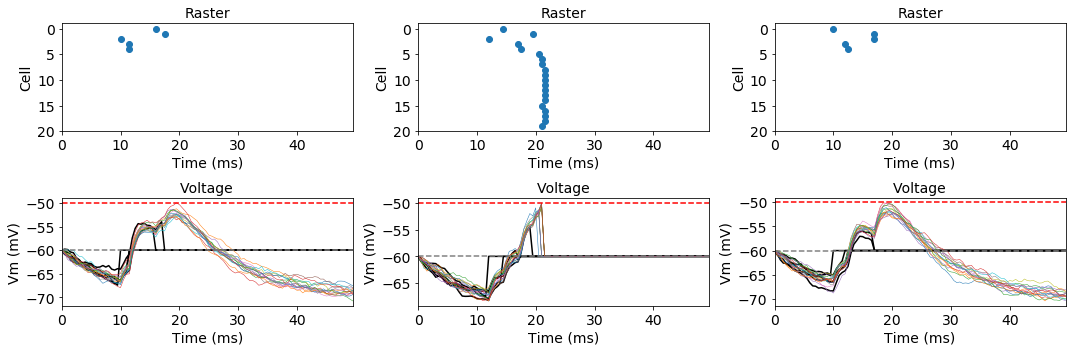

In [3]:
# ntwk params
m = copy(M)
m['N_L_E'] = 20  # num E nrns in chain link
m['E_L_E'] = -.06
m['V_R_E'] = -.06
m['W_E_E_R'] = 0.05e-3  # E->E recurrent cxns w/in link
m['T_R_E'] = 1  # inf refrac period
m['SGM_N'] = .3e-9  # Amp*sqrt(s)
m['I_EXT_B'] =  -.1e-5 # Amp

## E-E rcr weights
w_r_e_e = m['W_E_E_R'] * np.ones([m['N_L_E']]*2)

w_r = {
    'E': w_r_e_e,
    'I': np.zeros((m['N_L_E'], m['N_L_E'])),
}

## input weights
w_u_e_e = 0
w_u_e_i = 0

w_u = {
    'E': cc([np.repeat(w_u_e_e, m['N_L_E']), np.zeros(m['N_L_E'])]),
    'I': cc([np.zeros(m['N_L_E']), np.repeat(w_u_e_e, m['N_L_E'])]),
}

ntwk = LIFNtwkG(
    c_m=m['C_M_E'],
    g_l=m['G_L_E'],
    e_l=m['E_L_E'],
    v_th=m['V_TH_E'],
    v_r=m['V_R_E'],
    t_r=m['T_R_E'],
    e_s={'E': m['E_E'], 'I': m['E_I']},
    t_s={'E': m['T_E'], 'I': m['T_E']},
    w_r=w_r,
    w_u=w_u)

# response
N_TRL = 3
N_SPK_0 = 5

t = np.arange(0, .05, S['DT'])

t_m_e = m['C_M_E']/m['G_L_E']
it_m_e = int(round(t_m_e/S['DT']))

## forced spikes
np.random.seed(S['RNG_SEED'])

rsps = []
for _ in range(N_TRL):
    # rand forced spk times w/in 1 time constant
    tmp = {}
    for c, it in enumerate(np.random.randint(0, it_m_e, N_SPK_0)):
        if it not in tmp:
            tmp[it] = np.eye(m['N_L_E'], dtype=bool)[c]
        else:
            tmp[it][c] = True
            
    spks_0 = {S['DT']*it + .01: spk for it, spk in tmp.items()}

    clamp = Generic(
        v={0: np.repeat(m['E_L_E'], m['N_L_E'])},
        spk=spks_0)

    ## inputs
    i_ext = m['SGM_N']/S['DT'] * np.random.randn(len(t), m['N_L_E']) + m['I_EXT_B']

    rsp = ntwk.run(dt=S['DT'], clamp=clamp, i_ext=i_ext)
    rsps.append(copy(rsp))
    
fig, axs = plt.subplots(2, N_TRL, figsize=(15, 5), tight_layout=True)

for rsp, axs_ in zip(rsps, axs.T):
    # raster
    it_spk, c_spk = np.nonzero(rsp.spks)
    t_spk = it_spk * S['DT']
    axs_[0].scatter(1000*t_spk, c_spk)
    axs_[0].set_xlim(1000*t.min(), 1000*t.max())
    axs_[0].set_ylim(m['N_L_E'], -1)
    
    axs_[0].set_xlabel('Time (ms)')
    axs_[0].set_ylabel('Cell')
    axs_[0].set_title('Raster')
    
    # voltages
    axs_[1].plot(1000*t, 1000*rsp.vs[:, :N_SPK_0], c='k')
    axs_[1].plot(1000*t, 1000*rsp.vs[:, N_SPK_0:], lw=.5)
    axs_[1].axhline(1000*m['E_L_E'], c='gray', ls='--')
    axs_[1].axhline(1000*m['V_TH_E'], c='r', ls='--')
    axs_[1].set_xlim(1000*t.min(), 1000*t.max())
    
    axs_[1].set_xlabel('Time (ms)')
    axs_[1].set_ylabel('Vm (mV)')
    axs_[1].set_title('Voltage')
    
for ax in axs.flatten():
    set_font_size(ax, 14)

## Full chain behavior

In [4]:
# ntwk params
m = copy(M)
m['N_L_E'] = 20  # num E nrns in chain link
m['N_L'] = 10  # num links
m['W_E_E_R'] = 0.05e-3  # E->E recurrent cxns w/in link
m['W_E_E_F'] = 0.05e-3  # E->E feed-forward cxns btwn links
m['T_R_E'] = np.inf  # inf refrac period

m['N_E'] = m['N_L']*m['N_L_E']

## E-E weights
w_r_e_e = \
    m['W_E_E_R'] * np.kron(np.eye(m['N_L'], k=0), np.ones([m['N_L_E']]*2)) + \   # w/in link
    m['W_E_E_F'] * np.kron(np.eye(m['N_L'], k=-1), np.ones([m['N_L_E']]*2))  # btwn links

w_r = {
    'E': w_r_e_e,
    'I': np.zeros((m['N_L_E'], m['N_L_E'])),
}

## input weights
w_u_e_e = ...
w_u_e_i = ...

w_u = {
    'E': w_u_e_e,
    'I': w_u_e_i,
}

# response

SyntaxError: unexpected character after line continuation character (<ipython-input-4-aa32a79cee55>, line 13)